# Clasificación con data de hundimiento del Titanic

In [1]:
# tomar información de distintas fuentes y generar métricas y modelos predictivos
# El resultado debe ser guardado en postgres o parquet
# crear visualizaciones para ilustrar el análisis y los datos

In [2]:
# Utilizo un DataSet de un área de turismo, de mi lugar de trabajo.
# por temas de confidencialidad, no muestro montos ni datos biográficos de personas.
# la estructura del DataSet es la siguiente
# HOTEL nombre del Hotel
# ANIO para la cual se hizo la reserva
# MES  para el cual se hizo la reserva
# DIAS cantidad de día de la  reserva
# HABITACIONES cantidad de habitaciones contratadas. No se cuenta con el dato de cantidade pasajeros, 
#              dado que se cobra por habitación

In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('venta_de_plazas').getOrCreate()

In [5]:
spark.version

'2.4.5'

In [6]:
dft = spark.read.csv('/dataset/venta_plazas.csv', header=True)

In [7]:
# utilizo el argumento truncate=false, para que me muestre todo el contenido del campo
dft.show(10, truncate=False)

+----------------------------+--------------+------------------------+----+----+-------+-----+
|HOTRAZONSOCIAL              |HOTLOCALIDAD  |ANIO                    |MES |DIAS|Importe|CARGO|
+----------------------------+--------------+------------------------+----+----+-------+-----+
|TRONADOR                    |MAR DEL PLATA |2020                    |4   |3   |9324   |1190 |
|HOSTERÍA DEL CERRO          |VILLA CATEDRAL| SAN CARLOS DE BARILOCHE|2021|10  |7      |25991|
|ARENA RESORT HOTEL          |FEDERACION    | ENTRE RIOS             |2022|4   |4      |38808|
|ALTOS DE MERLO              |VILLA DE MERLO|2020                    |2   |8   |38880  |1161 |
|TRONADOR                    |MAR DEL PLATA |2023                    |2   |4   |118800 |1161 |
|PREMIUM TOWER SUITES MENDOZA|MENDOZA       |2022                    |7   |7   |65939  |1154 |
|PREMIUM TOWER SUITES MENDOZA|MENDOZA       |2022                    |7   |7   |118664 |1180 |
|PREMIUM TOWER SUITES MENDOZA|MENDOZA       |2022 

In [8]:
dft.printSchema()

root
 |-- HOTRAZONSOCIAL: string (nullable = true)
 |-- HOTLOCALIDAD: string (nullable = true)
 |-- ANIO: string (nullable = true)
 |-- MES: string (nullable = true)
 |-- DIAS: string (nullable = true)
 |-- Importe: string (nullable = true)
 |-- CARGO: string (nullable = true)



In [9]:
# defino la función para castear los tipos en las columnas

In [10]:
from pyspark.sql.types import DoubleType, IntegerType

In [11]:
import pyspark.sql.functions as f

In [12]:
def cast_cols(df, cols, new_type):
  for col in cols: 
     df = df.withColumn(col, df[col].cast(new_type()))
  return df

In [13]:
integer_cols = ['ANIO', 'MES', 'MES', 'DIAS']

In [14]:
dft = cast_cols(dft, integer_cols, IntegerType)

In [15]:
dft = dft.withColumn('Importe', f.col('Importe').cast('double'))

In [16]:
dft.printSchema()

root
 |-- HOTRAZONSOCIAL: string (nullable = true)
 |-- HOTLOCALIDAD: string (nullable = true)
 |-- ANIO: integer (nullable = true)
 |-- MES: integer (nullable = true)
 |-- DIAS: integer (nullable = true)
 |-- Importe: double (nullable = true)
 |-- CARGO: string (nullable = true)



In [17]:
# inpororo la función de spark para quitar los espacios en el nombre del Hotel, y hacer las agregaciones

In [18]:
dft = dft.withColumn('HOTRAZONSOCIAL', f.trim(dft['HOTRAZONSOCIAL']))

In [19]:
from datetime import datetime
# Obtengo  el año actual
anio_actual = datetime.now().year

In [20]:
# Obtengo  el año anterioractual
anio_anterior = anio_actual -1

In [21]:
# Filtra los datos para mantener solo los registros con ANIO igual a anterior o actual
filtered_data = dft.filter((f.col('ANIO') == anio_anterior) | (f.col('ANIO') == anio_actual))

In [22]:
# Utiliza la función 'when' para crear dos columnas condicionales para anterior y actual
filtered_data = filtered_data.withColumn('qty_anterior', f.when(f.col('ANIO') == anio_anterior, 1).otherwise(0))
filtered_data = filtered_data.withColumn('qty_actual', f.when(f.col('ANIO') == anio_actual, 1).otherwise(0))

In [23]:
# Luego, agrupa por 'HOTEL' y suma los valores condicionales para anterior y actual
filtered_data = filtered_data.groupBy('HOTRAZONSOCIAL').agg(f.sum('qty_anterior').alias('qty_anterior'), f.sum('qty_actual').alias('qty_actual'))

In [24]:
# Ordena los resultados en orden descendente por 'qty_actual'
filtered_data = filtered_data.orderBy('qty_actual', ascending=False)

In [25]:
# Muestra los primeros 10 resultados sin truncar más vendidos
filtered_data.show(10, truncate=False)

+---------------------------------+------------+----------+
|HOTRAZONSOCIAL                   |qty_anterior|qty_actual|
+---------------------------------+------------+----------+
|DESIGN BUENOS AIRES              |221         |223       |
|TRONADOR                         |195         |217       |
|PARADISO PLAYA                   |121         |149       |
|PORTAL DEL IGUAZÚ                |82          |140       |
|CABAÑAS PUERTO HAMLET            |146         |138       |
|SAVOIA - OSTENDE                 |137         |126       |
|PREMIUM TOWER SUITES MENDOZA     |175         |120       |
|HOWARD JOHNSON PLAZA BUENOS AIRES|116         |115       |
|DESIGN BARILOCHE                 |62          |96        |
|LAS CUMBRES                      |34          |88        |
+---------------------------------+------------+----------+
only showing top 10 rows



In [26]:
# Ordena los resultados en orden asscendente por 'qty_actual'
filtered_data = filtered_data.orderBy('qty_actual', ascending=True)

In [27]:
# Muestra los primeros 10 resultados sin truncar menos vendidos
filtered_data.show(10, truncate=False)

+-----------------------------+------------+----------+
|HOTRAZONSOCIAL               |qty_anterior|qty_actual|
+-----------------------------+------------+----------+
|HOTEL LIBERTADOR ****        |1           |2         |
|SOHO SUITES                  |4           |3         |
|PREMIUM TOWER SAN LUIS       |19          |5         |
|MÉRIT - PUERTO IGUAZÚ        |29          |8         |
|PINARES PANORAMA SUITES & SPA|1           |9         |
|HOTEL HUAICO                 |1           |11        |
|RESIDENCIA PARQUE BONITO     |8           |14        |
|SAN CARLOS INN               |4           |14        |
|HOTEL SANTA ELÍA             |19          |16        |
|ALTOS DE MERLO               |22          |27        |
+-----------------------------+------------+----------+
only showing top 10 rows



In [28]:
# Por la altura del año en donde se procesa, se deduce que los que tienen qty_actual en cero, 
# se debe a que dejaron de trabajar con el sector de turismo
# Se eliminan del DataSet, ya que no se puede predecir sobre los mismos

In [29]:
dft.count()

7831

In [30]:
# Filtra los hoteles en dft que cumplan con la condición requerida
dft = dft.join(
    filtered_data,
    ['HOTRAZONSOCIAL'],
    'left_outer'
)

In [31]:
dft.count()

7831

In [32]:
# Elimino los cargos 9638 y JJJJ, porque al tratarse de Jubilados, no se puede obtener el sueldo y no son referencia

In [33]:
dft = dft.filter((f.col('CARGO') != '9638') & (f.col('CARGO') != 'JJJJ') )

In [34]:
dft.count()

7260

In [35]:
# Leo los sueldos, con sus incrementos

In [36]:
dfs = spark.read.csv('/dataset/salarios.csv', header=True)

In [37]:
dfs.printSchema()

root
 |-- Anio: string (nullable = true)
 |-- Mes: string (nullable = true)
 |-- Cargo: string (nullable = true)
 |-- Descripción: string (nullable = true)
 |-- Sueldo: string (nullable = true)



In [38]:
# convierto los campos

In [39]:
integer_cols = ['ANIO', 'MES']
dfs = cast_cols(dfs, integer_cols, IntegerType)

In [40]:
dfs.printSchema()

root
 |-- ANIO: integer (nullable = true)
 |-- MES: integer (nullable = true)
 |-- Cargo: string (nullable = true)
 |-- Descripción: string (nullable = true)
 |-- Sueldo: string (nullable = true)



In [41]:
dfs = dfs.withColumn('Sueldo', f.col('Sueldo').cast('double'))

In [42]:
from pyspark.sql.window import Window

In [43]:
# Define una ventana ordenada por 'CARGO', 'ANIO' y 'MES' para usarla en la operación de unión
window = Window.partitionBy('CARGO').orderBy('ANIO', 'MES')

In [44]:
# Agrega una columna de rango para determinar el orden de los registros en 'dfs'
dfs = dfs.withColumn('rank', f.row_number().over(window))

In [45]:
# Filtra 'dfs' para mantener solo el valor más reciente de cada CARGO
dfs = dfs.filter(f.col('rank') == 1).drop('rank')

In [46]:
# Realiza una operación de unión (join) entre 'dft' y 'dfs' basada en 'CARGO', 'ANIO' y 'MES'
result = dft.join(dfs, on=['CARGO', 'ANIO', 'MES'], how='left_outer')

In [47]:
# Rellena los valores faltantes en 'sueldo' con el valor inmediatamente anterior si es nulo
result = result.withColumn('sueldo', f.last('sueldo', ignorenulls=True).over(window))

In [48]:
# Elimina la columna 'rank' que ya no es necesaria
result = result.drop('rank')

In [49]:
result.printSchema()

root
 |-- CARGO: string (nullable = true)
 |-- ANIO: integer (nullable = true)
 |-- MES: integer (nullable = true)
 |-- HOTRAZONSOCIAL: string (nullable = true)
 |-- HOTLOCALIDAD: string (nullable = true)
 |-- DIAS: integer (nullable = true)
 |-- Importe: double (nullable = true)
 |-- qty_anterior: long (nullable = true)
 |-- qty_actual: long (nullable = true)
 |-- Descripción: string (nullable = true)
 |-- sueldo: double (nullable = true)



In [50]:
result.count()

7260

In [51]:
import seaborn as sns

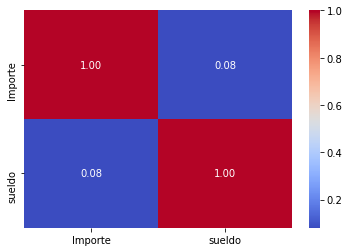

In [52]:
g = sns.heatmap(result.select('CARGO', 'Importe', 'sueldo').toPandas().corr(),
                annot=True, fmt = ".2f", cmap = "coolwarm")

In [53]:
# Implemento un modelo con árboles de decision

In [54]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler

In [55]:
result = result.na.drop()

In [56]:
feature_columns = ["ANIO", "MES", "Importe", "DIAS", "qty_anterior", "qty_actual"]

In [57]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="keep")

In [58]:
spark = SparkSession.builder.appName("DecisionTreeRegression").getOrCreate()

In [59]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [60]:
result = assembler.transform(result)

In [61]:
train_data, test_data = result.randomSplit([0.8, 0.2], seed=20993750)

In [62]:
dt = DecisionTreeRegressor(featuresCol="features", labelCol="DIAS")
model = dt.fit(train_data)

In [63]:
predictions = model.transform(test_data)

In [64]:
from pyspark.ml.evaluation import RegressionEvaluator

In [65]:
evaluator = RegressionEvaluator(labelCol="DIAS", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 0.25000000000000006


In [68]:
# Se especifica la ruta y nombre donde se guardará el archivo Parquet
archivo_guardado = "/dataset/archivo_parquet/estadisticaplaza.parquet"

# Utiliza el método write.parquet() para guardar el DataFrame en formato Parquet
result.write.parquet(archivo_guardado)

In [69]:
spark.stop()